# Train NanoDet with custom dataset
<a target="_blank" href="https://colab.research.google.com/github/SonySemiconductorSolutions/aitrios-rpi-tutorials-ai-model-training/blob/main/notebooks/nanodet-ppe/custom_nanodet.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Training NanoDet model to detect Personal Protection Equipment (PPE) using open source dataset.

Nanodet training based on https://github.com/RangiLyu/nanodet/tree/main

Tutorial includes:
- Dataset setup
- Nanodet model setup
- Training
- Quantization using [Model Compression Toolkit - MCT](https://github.com/sony/model_optimization)

In [1]:
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cu117
!pip install model-compression-toolkit roboflow
!pip install "tensorflow==2.14"

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [2]:
# Perform initial checks in order to continue
import tensorflow as tf
import torch
import psutil

assert '2.14' in tf.__version__, print(tf.__version__)
assert '1.13' in torch.__version__, print(torch.__version__)

# Check available memory
mem = psutil.virtual_memory()
mem_in_gb = mem.total / (1024 ** 3)
print(f"Total memory: {mem_in_gb:.2f}GB")
print(tf.config.list_physical_devices('GPU'))
print(f'Is cuda available: {torch.cuda.is_available()}')
assert mem_in_gb >= 12 or torch.cuda.is_available()

c:\Users\Peter\miniconda3\envs\nanodet\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total memory: 31.88GB
[]
Is cuda available: True


# Installation

In [3]:
"""
Known errors:
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.13.1 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.13.1 which is incompatible.
"""
NANODET_COMMIT = 'be9b4a9'
!git clone https://github.com/RangiLyu/nanodet.git
!type NUL > nanodet/nanodet/model/__init__.py
!cd nanodet && git checkout {NANODET_COMMIT} && pip install -q --no-cache-dir -r requirements.txt

fatal: destination path 'nanodet' already exists and is not an empty directory.
HEAD is now at be9b4a9 Replaced opencv with imagesize to get the actual image size (#548)


# Dataset
- go to https://universe.roboflow.com/ai-camp-safety-equipment-detection/ppe-detection-using-cv/dataset/3 and click `"Download Dataset"`
- choose format `"COCO"` and `"show download code"` and `"continue"`
- choose `"Terminal"` and copy the command `"curl..."` and paste the command in the cell below.
- add `"!"` in the beginning of the command and replace `"\&gt;"` with `">"`

In [4]:
# Add below your download code from Roboflow, it should look like the following, with your unique roboflow dataset url:
# Example (with "!" added in the beginning of the command and replaced "&gt;" with ">". Also added "-q" for less output):
# !curl -L "https://universe.roboflow.com/ds/<unique-dataset-url>" > roboflow.zip; unzip -q roboflow.zip; rm roboflow.zip

from roboflow import Roboflow

import os
from dotenv import load_dotenv

# Load variables from .env file
load_dotenv()


rf = Roboflow(os.getenv("roboflow"))
project = rf.workspace("rocks-rkbw8").project("rock-detection-dvadl")
version = project.version(1)
dataset = version.download("coco")
                


loading Roboflow workspace...
loading Roboflow project...


In [5]:
# Move test/train/valid to dataset folder
from pathlib import Path
DATASET_PATH = 'Rock-Detection-1'
if not Path(f'{DATASET_PATH}/train/_annotations.coco.json').exists():
    assert Path(f'train/_annotations.coco.json').exists()
    assert Path(f'valid/_annotations.coco.json').exists()
    assert Path(f'test/_annotations.coco.json').exists()
    !mkdir -p $DATASET_PATH
    !mv test train valid *txt $DATASET_PATH/

In [6]:
assert Path(f'{DATASET_PATH}/train/_annotations.coco.json').exists()
assert Path(f'{DATASET_PATH}/valid/_annotations.coco.json').exists()

# Training config file: nanodet-plus-m-1.5x_416-ppe.yml
The following block of code creates the NanoDet training config file which
is based on nanodet/config/nanodet-plus-m-1.5x_416.yml.
Updated for the custom PPE dataset
Change number of `total_epochs` for better performance.

If training on GPU, then set   `gpu_ids`:
 * 1 gpu: [0]
 * 2 gpu: [0,1]
 * etc...

Increase `total_epochs`, for example 20.

Feel free to increase `val_intervals`, for example 10.

For details see NanoDet github repo and [config docs](https://github.com/RangiLyu/nanodet/blob/main/docs/config_file_detail.md). Observe recommendation to adjust `lr` with `batch_size`.

# Training

In [8]:
# OBSERVE: update the following assert statement to match your yml file settings.

import yaml
with open('nanodet-plus-m-1.5x_416-ppe.yml', 'r') as file:
    config = yaml.safe_load(file)

assert config['device']['gpu_ids'] == -1 or config['device']['gpu_ids'] == [0], print(f"gpu_ids: {config['device']['gpu_ids']}")
assert config['schedule']['total_epochs'] == 2 or config['schedule']['total_epochs'] == 20, print(f"total_epochs: {config['schedule']['total_epochs']}")
assert config['schedule']['val_intervals'] == 1 or config['schedule']['val_intervals'] == 10, print(f"val_intervals: {config['schedule']['val_intervals']}")

In [9]:
import json
from pathlib import Path

# Path to your COCO annotations file
annotations_path = Path('Rock-Detection-1/train/_annotations.coco.json')

# Load the annotations
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Extract class names
categories = annotations.get('categories', [])
class_names = [category['name'] for category in categories]

print("Class Names:", class_names)

Class Names: ['Rocks-lAGt', 'Float_Rock', 'stone']


In [17]:
'''import torch
assert '1.13' in torch.__version__, print(torch.__version__)
assert Path('nanodet-plus-m-1.5x_416-ppe.yml').exists()
!export PYTHONPATH=$PWD/nanodet:$PYTHONPATH && python nanodet/tools/train.py nanodet-plus-m-1.5x_416-ppe.yml'''

import torch
from pathlib import Path
import os
assert '1.13' in torch.__version__, print(torch.__version__)
assert Path('nanodet-plus-m-1.5x_416-ppe.yml').exists()
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTHONPATH'] = f"{os.getcwd()}/nanodet;{os.environ.get('PYTHONPATH', '')}"


#sometime i should make this work without a shell command
!"python.exe" ../nanodet/tools/train.py nanodet-plus-m-1.5x_416-ppe.yml

loading annotations into memory...

[NanoDet][02-08 21:47:20]INFO:Setting up data...
[NanoDet][02-08 21:47:20]INFO:Creating model...
Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type        | Params
------------------------------------------
0 | model     | NanoDetPlus | 7.7 M 
1 | avg_model | NanoDetPlus | 7.7 M 
------------------------------------------
15.5 M    Trainable params
0         Non-trainable params
15.5 M    Total params
30.980    Tota


Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
model size is  1.5x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1_5-3c479a10.pth
Finish initialize NanoDet-Plus Head.
Loading and preparing results...
DONE (t=0.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.22s).
Accumulating evaluation results...
DONE (t=0.18s).
Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.85s).
Accumulating evaluation results...
DONE (t=0.19s).
Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.72s).
Accumulating evaluation results...
DONE (t=0.13s).
Loading and preparing results...
DONE (t=0.25s)
creating index..

# Remove aux layers that are only used during training

In [18]:
import sys
sys.path.insert(0,"./nanodet")

import copy
import torch
from nanodet.model.arch import build_model
from nanodet.util import cfg, load_config, Logger

def remove_aux(cfg, model_path, remove_layers=['aux_fpn', 'aux_head'], debug=False):
    model = build_model(cfg.model)
    ckpt = torch.load(model_path, map_location=lambda storage, loc: storage)
    if len(remove_layers) > 0:
        state_dict = copy.deepcopy(ckpt['state_dict'])
        for rlayer in remove_layers:
            for layer in ckpt['state_dict']:
                if rlayer in layer:
                    del state_dict[layer]
                    if debug:
                        print(f'removed layer: {layer}')
        del ckpt['state_dict']
        ckpt['state_dict'] = copy.deepcopy(state_dict)
        del state_dict
    return ckpt

In [20]:
config_path = 'nanodet-plus-m-1.5x_416-ppe.yml'
model_path = 'workspace/nanodet-plus-m-1.5x_416-ppe/model_best/nanodet_model_best.pth'

dst_path = 'workspace/nanodet-plus-m-1.5x_416-ppe/model_best/nanodet_model_best-removed-aux.pth'

load_config(cfg, config_path)
ckpt = remove_aux(cfg, model_path, ['aux_fpn', 'aux_head'])
torch.save(ckpt, dst_path)
print(f'Saved to: {dst_path}')

model size is  1.5x
init weights...
=> loading pretrained model https://download.pytorch.org/models/shufflenetv2_x1_5-3c479a10.pth
Finish initialize NanoDet-Plus Head.
Saved to: workspace/nanodet-plus-m-1.5x_416-ppe/model_best/nanodet_model_best-removed-aux.pth


In [21]:
# Compare size w and w/o aux
!ls -l workspace/nanodet-plus-m-1.5x_416-ppe/model_best

'ls' is not recognized as an internal or external command,
operable program or batch file.


# Quantization of custom NanoDet model using Model Compression Toolkit
Quantization is based on https://github.com/sony/model_optimization/blob/v2.0.0/tutorials/notebooks/keras/ptq/example_keras_nanodet_plus.ipynb

# Installation

In [22]:
import sys
MCT_COMMIT = 'v2.1.0'
!git clone https://github.com/sony/model_optimization.git local_mct && cd local_mct && git checkout {MCT_COMMIT} && pip install --no-cache-dir -r requirements.txt
sys.path.insert(0,"./local_mct")

  Attempting uninstall: mct-quantizers
    Found existing installation: mct-quantizers 1.5.2
    Uninstalling mct-quantizers-1.5.2:
      Successfully uninstalled mct-quantizers-1.5.2


Cloning into 'local_mct'...
Note: switching to 'v2.1.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9d3593f8 Release 2.1.0 + docs (#1085)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
model-compression-toolkit 2.2.2 requires mct-quantizers==1.5.2, but you have mct-quantizers 1.5.0 which is incompatible.


# Keras NanoDet float model

In [23]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import torch
assert '2.14' in tf.__version__, print(tf.__version__)
assert '1.13' in torch.__version__, print(torch.__version__)

from keras.models import Model
import model_compression_toolkit as mct
from tutorials.mct_model_garden.models_keras.nanodet.nanodet_keras_model import nanodet_plus_m
from tutorials.mct_model_garden.models_keras.utils.torch2keras_weights_translation import load_state_dict
from tutorials.mct_model_garden.models_keras.nanodet.nanodet_keras_model import nanodet_box_decoding
assert 'local_mct' in mct.__file__, print(mct.__file__)


In [24]:
# Upload the trained custom model
CUSTOM_WEIGHTS_FILE = dst_path  # The NanoDet model trained with PPE dataset
CLASS_NAMES = ['Rocks-lAGt', 'Float_Rock', 'stone']
NUM_CLASSES = len(CLASS_NAMES)

DATASET_TRAIN = DATASET_PATH
ANNOT_TRAIN = DATASET_PATH + '/train/_annotations.coco.json'
DATASET_VALID = DATASET_PATH + '/valid'
ANNOT_VALID = DATASET_PATH + '/valid/_annotations.coco.json'
DATASET_REPR = DATASET_VALID
ANNOT_REPR = ANNOT_VALID

QUANTIZED_MODEL_NAME = 'nanodet-quant-ppe.keras'

BATCH_SIZE = 5
N_ITER = 20  # 1 for testing, otherwise 20

assert Path(CUSTOM_WEIGHTS_FILE).exists()
assert Path(DATASET_REPR).exists()

In [25]:

def get_model(weights=CUSTOM_WEIGHTS_FILE, num_classes=NUM_CLASSES):
    INPUT_RESOLUTION = 416
    INPUT_SHAPE = (INPUT_RESOLUTION, INPUT_RESOLUTION, 3)
    SCALE_FACTOR = 1.5
    BOTTLENECK_RATIO = 0.5
    FEATURE_CHANNELS = 128

    pretrained_weights = torch.load(weights, map_location=torch.device('cpu'))['state_dict']
    # Generate Nanodet base model
    model = nanodet_plus_m(INPUT_SHAPE, SCALE_FACTOR, BOTTLENECK_RATIO, FEATURE_CHANNELS, num_classes)

    # Set the pre-trained weights
    load_state_dict(model, state_dict_torch=pretrained_weights)

    # Add Nanodet Box decoding layer (decode the model outputs to bounding box coordinates)
    scores, boxes = nanodet_box_decoding(model.output, res=INPUT_RESOLUTION, num_classes=num_classes)

    # Add TensorFlow NMS layer
    outputs = tf.image.combined_non_max_suppression(
        boxes,
        scores,
        max_output_size_per_class=300,
        max_total_size=300,
        iou_threshold=0.65,
        score_threshold=0.001,
        pad_per_class=False,
        clip_boxes=False
        )

    model = Model(model.input, outputs, name='Nanodet_plus_m_1.5x_416')

    print('Model is ready for evaluation')
    return model

In [26]:
# known warning:  WARNING: head.distribution_project.project not assigned to keras model !!!
float_model = get_model(CUSTOM_WEIGHTS_FILE, NUM_CLASSES)

Model is ready for evaluation


# PTQ quantization

In [27]:
from typing import Callable, Iterator, Tuple, List

import cv2
from tutorials.mct_model_garden.evaluation_metrics.coco_evaluation import coco_dataset_generator, CocoEval

def nanodet_preprocess(x):
    img_mean = [103.53, 116.28, 123.675]
    img_std = [57.375, 57.12, 58.395]
    x = cv2.resize(x, (416, 416))
    x = (x - img_mean) / img_std
    return x

def get_representative_dataset(n_iter: int, dataset_loader: Iterator[Tuple]):
    def representative_dataset() -> Iterator[List]:
        ds_iter = iter(dataset_loader)
        for _ in range(n_iter):
            yield [next(ds_iter)[0]]

    return representative_dataset

def quantization(float_model, dataset, annot, n_iter=N_ITER):
    # Load representative dataset
    representative_dataset = coco_dataset_generator(dataset_folder=dataset,
                                                    annotation_file=annot,
                                                    preprocess=nanodet_preprocess,
                                                    batch_size=BATCH_SIZE)

    tpc = mct.get_target_platform_capabilities('tensorflow', 'imx500')

    # Preform post training quantization
    quant_model, _ = mct.ptq.keras_post_training_quantization(
        float_model,
        representative_data_gen=get_representative_dataset(n_iter, representative_dataset),
        target_platform_capabilities=tpc)

    print('Quantized model is ready')
    return quant_model

In [28]:
quant_model = quantization(float_model, DATASET_REPR, ANNOT_REPR)
print(f'Representative dataset: {DATASET_REPR}')

Statistics Collection: 20it [00:53,  2.70s/it]



Running quantization parameters search. This process might take some time, depending on the model size and the selected quantization methods.



Calculating quantization parameters: 100%|██████████| 384/384 [00:09<00:00, 41.06it/s] 
overflow encountered in scalar multiply



Please run your accuracy evaluation on the exported quantized model to verify it's accuracy.
Checkout the FAQ and Troubleshooting pages for resolving common issues and improving the quantized model accuracy:
FAQ: https://github.com/sony/model_optimization/tree/main/FAQ.md
Quantization Troubleshooting: https://github.com/sony/model_optimization/tree/main/quantization_troubleshooting.md
Quantized model is ready
Representative dataset: Rock-Detection-1/valid


In [29]:
# Observe that loading quantized model might require specification of custom layers,
# see https://github.com/sony/model_optimization/issues/1104
quant_model.save(QUANTIZED_MODEL_NAME)
print(f'Quantized model saved: {QUANTIZED_MODEL_NAME}')

Quantized model saved: nanodet-quant-ppe.keras


_todo_: coco evaluation of the custom quantized NanoDet model requires some update to the mct repo.

# Visualize detection

In [31]:
# Helper functions for visualization
import numpy as np

def load_and_preprocess_image(image_path: str, preprocess: Callable) -> np.ndarray:
    """
    Load and preprocess an image from a given file path.

    Args:
        image_path (str): Path to the image file.
        preprocess (function): Preprocessing function to apply to the loaded image.

    Returns:
        numpy.ndarray: Preprocessed image.
    """
    image = cv2.imread(image_path)
    image = preprocess(image)
    image = np.expand_dims(image, 0)
    return image

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation, scale, class_id, score):
    row = scale[0]
    col = scale[1]
    x_min, y_min = int(annotation[1]*col), int(annotation[0]*row)
    x_max, y_max = int(annotation[3]*col), int(annotation[2]*row)

    color = (0,255,0)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    text = f'{int(class_id)}: {score:.2f}'
    cv2.putText(img, text, (x_min + 10, y_min + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, output, scale, quantized_model=False, threshold=0.55):
    if quantized_model:
        b = output[0].numpy()[0]
        s = output[1].numpy()[0]
        c = output[2].numpy()[0]
    else:
        print('Assuming float model')
        b = output.nmsed_boxes.numpy()[0]
        s = output.nmsed_scores.numpy()[0]
        c = output.nmsed_classes.numpy()[0]
    for index, row in enumerate(b):
        if s[index] > threshold:
            #print(f'row: {row}')
            id = int(c[index])
            draw_bounding_box(img, row, scale, id, s[index])
            print(f'class: {CLASS_NAMES[id]} ({id}), score: {s[index]:.2f}')
    return {'bbox':b, 'score':s, 'classes':c}

image shape: (640, 640, 3)
Annotated image saved to: annotated.jpg


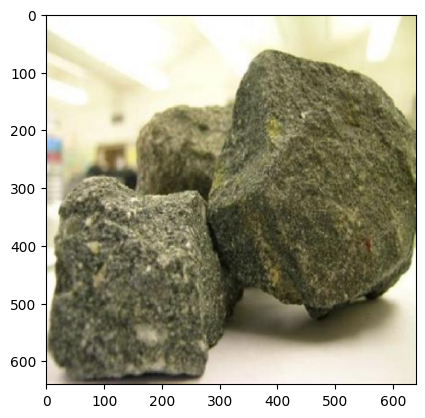

In [ ]:
# See appendix for results. For 2 epochs, the bounding boxes are not perfect...
# But improves considerably for 20 epochs.
test_img = 'rock.jpg'
img = load_and_preprocess_image(f'{test_img}', nanodet_preprocess)
output = quant_model(img)
image = cv2.imread(f'{test_img}')
print(f'image shape: {image.shape}')
r = annotate_image(image, output, scale=image.shape, quantized_model=True)
assert r['score'][0] > 0.5, print(f"r['score'][0] > 0.5 failed: {r['score'][0]}")
dst = f'annotated.jpg'
if cv2.imwrite(dst, image):
    print(f'Annotated image saved to: {dst}')
else:
    print(f'Failed saving annotated image')
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
!pip install imx500-converter[tf]

In [34]:
!imxconv-tf -i nanodet-quant-ppe.keras -o converted_tf/

2025-02-09 16:13:18,075 INFO : Running version 1.10.0 [C:\Users\Peter\miniconda3\envs\nanodet\lib\site-packages\uni\common\logger.py:148]
2025-02-09 16:13:18,075 INFO : Converting nanodet-quant-ppe.keras [C:\Users\Peter\miniconda3\envs\nanodet\lib\site-packages\uni\common\logger.py:148]
2025-02-09 16:13:34,924 INFO : Wrote outputs to C:\Users\Peter\AppData\Local\Temp\tmptw40ij6g/nanodet-quant-ppe.uni-tensorflow.um.pb [C:\Users\Peter\miniconda3\envs\nanodet\lib\site-packages\uni\common\logger.py:148]
2025-02-09 16:13:34,944 INFO : Converted successfully [C:\Users\Peter\miniconda3\envs\nanodet\lib\site-packages\uni\common\logger.py:148]
2025-02-09 16:13 WARNING: Script 'converter-frontend.bat' does not exist in C:\Users\Peter\miniconda3\envs\nanodet\Lib\site-packages\sdspconv_wrapper\sdspconv-dist.
2025-02-09 16:13 WARNING: Script 'tiling-advisor.bat' does not exist in C:\Users\Peter\miniconda3\envs\nanodet\Lib\site-packages\sdspconv_wrapper\sdspconv-dist.
2025-02-09 16:13 WARNING: Scrip

2025-02-09 16:13:18.100037: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Run on the Pi:

In [3]:
!imx500-package -i converted_tf/packerOut.zip -o IMX500_network/network_v2.rpk
!./update_intrinsics.sh IMX500_network/network_v2.rpk intrinsics.json

Archive:  /home/petervine/IMX500RockModel/converted_tf/packerOut.zip
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/sdpsA.bin  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/sdpsC.bin  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/cfgA.bin  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/cfgC.bin  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/dnnParams.xsd  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/dnnParams.xml  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/l2staticData.bin  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/verTable.txt  
  inflating: /tmp/imx500-tools.oolG952gPK/packer_output/manifest.json  
/tmp/imx500-tools.oolG952gPK ~/IMX500RockModel
/usr/lib/imx500-tools/postconverter/CustomNetwork/input_format.json File exists!!
/tmp/imx500-tools.oolG952gPK/packer_output /tmp/imx500-tools.oolG952gPK
Check PackerOut Files
./sdpsA.bin File exists!!
./sdpsC.bin File exists!!
./cfgA.bin File exists!!

# Next step
__OBSERVE__: First, save the quantized model to your local machine. You will need it for the conversion and packaging steps.

Next step is to convert and package the model for IMX500. _todo: link to further instructions. This model requires bgr settings in the post-converter._

# Appendix
## Results total_epochs=2
```
[NanoDet][07-12 10:47:40]INFO:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.191
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.026
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.076
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.224
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.271

[NanoDet][07-12 10:47:40]INFO:
| class            | AP50   | mAP   | class     | AP50   | mAP   |
|:-----------------|:-------|:------|:----------|:-------|:------|
| Safety-Equipment | nan    | nan   | Person    | 54.1   | 20.1  |
| goggles          | 1.6    | 0.4   | helmet    | 40.3   | 13.4  |
| no-goggles       | 6.9    | 2.3   | no-helmet | 0.0    | 0.0   |
| no-vest          | 3.9    | 1.0   | vest      | 27.1   | 7.9   |
[NanoDet][07-12 10:47:40]INFO:Saving model to workspace/nanodet-plus-m-1.5x_416-ppe/model_best/nanodet_model_best.pth
[NanoDet][07-12 10:47:40]INFO:Val_metrics: {'mAP': 0.06442128900684024, 'AP_50': 0.1912998265318579, 'AP_75': 0.026441697602184976, 'AP_small': 0.010583883892274994, 'AP_m': 0.044976540581496194, 'AP_l': 0.0756733533889817}
`Trainer.fit` stopped: `max_epochs=2` reached.
```
## Results total_epochs=20
```
Comments:
-  based on nanodet/config/nanodet-plus-m-1.5x_416.yml
-  "device": settings for colab T4 GPU
-  "total_epochs": set to 20 during testing, default 300
...
[NanoDet][05-16 09:25:43]INFO:
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.479
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.497
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.185
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.414
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570

[NanoDet][05-16 09:25:43]INFO:
| class            | AP50   | mAP   | class     | AP50   | mAP   |
|:-----------------|:-------|:------|:----------|:-------|:------|
| Safety-Equipment | nan    | nan   | Person    | 86.4   | 49.3  |
| goggles          | 35.7   | 15.4  | helmet    | 86.0   | 46.3  |
| no-goggles       | 42.6   | 16.6  | no-helmet | 34.2   | 13.8  |
| no-vest          | 59.6   | 26.3  | vest      | 82.5   | 42.8  |
[NanoDet][05-16 09:25:44]INFO:Saving model to workspace/nanodet-plus-m-1.5x_416-ppe/model_best/nanodet_model_best.pth
[NanoDet][05-16 09:25:44]INFO:Val_metrics: {'mAP': 0.3006027561087712, 'AP_50': 0.6099170448933922, 'AP_75': 0.2496291506747232, 'AP_small': 0.07788513248169772, 'AP_m': 0.212229159695, 'AP_l': 0.36198435595574324}
`Trainer.fit` stopped: `max_epochs=20` reached.

real	21m35.722s
user	25m48.699s
sys	6m6.849s
```